In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [0]:
import os
os.chdir("/content/drive/My Drive/Analítica Predictiva/Taller1")

In [0]:
!ls

En los ejemplos realizados en este cuaderno se utilizaran modelos preentrenados. Estos modelos y las herramenitas para modificarlos se encuentran en las librerias TENSORNETS creadas por Taehoon Lee. Estas se pueden encontrar en el repositorio:
https://github.com/taehoonlee/tensornets
para instalar estas librerias se requiere cython por lo que se instalan los dos en la siguiente celda

In [0]:
!pip install cython
!pip install tensornets

En el siguiente ejemplo se muestra como cargar una arquitectura pre-entrenada para usarla con un dato nuevo.

In [0]:

import tensorflow as tf
import tensornets as nets


tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, 64, 64, 3])
model = nets.ResNet50(inputs)
assert isinstance(model, tf.Tensor)

img = nets.utils.load_img('usb_prueba.jpg', target_size=256, crop_size=64)
assert img.shape == (1, 64, 64, 3)

with tf.Session() as sess:
    img = model.preprocess(img)  # equivalent to img = nets.preprocess(model, img)
    sess.run(model.pretrained())  # equivalent to nets.pretrained(model)
    preds = sess.run(model, {inputs: img})

print(nets.utils.decode_predictions(preds, top=2)[0])

Pero si lo que queremos es usar una salida intermedia de la arquitectura preentrenada para entrenar el resto con nuestros datos seguimos el siguiente procedimiento usando las funciones  get_middles() y get_outputs():

In [0]:
import tensorflow as tf
import tensornets as nets

tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, 64, 64, 3])
model = nets.ResNet50(inputs)
assert isinstance(model, tf.Tensor)

img = nets.utils.load_img('usb_prueba.jpg', target_size=256, crop_size=64)
assert img.shape == (1, 64, 64, 3)

with tf.Session() as sess:
    img = model.preprocess(img)
    sess.run(model.pretrained())
    middles = sess.run(model.get_middles(), {inputs: img})
    outputs = sess.run(model.get_outputs(), {inputs: img})
    
model.print_summary()

model.print_middles()
assert middles[0].shape == (1, 16, 16, 256)
assert middles[-1].shape == (1, 2, 2, 2048)

model.print_outputs()

Scope: resnet50
Total layers: 54
Total weights: 320
Total parameters: 25,636,712
Scope: resnet50
conv2/block1/out:0 (?, 16, 16, 256)
conv2/block2/out:0 (?, 16, 16, 256)
conv2/block3/out:0 (?, 16, 16, 256)
conv3/block1/out:0 (?, 8, 8, 512)
conv3/block2/out:0 (?, 8, 8, 512)
conv3/block3/out:0 (?, 8, 8, 512)
conv3/block4/out:0 (?, 8, 8, 512)
conv4/block1/out:0 (?, 4, 4, 1024)
conv4/block2/out:0 (?, 4, 4, 1024)
conv4/block3/out:0 (?, 4, 4, 1024)
conv4/block4/out:0 (?, 4, 4, 1024)
conv4/block5/out:0 (?, 4, 4, 1024)
conv4/block6/out:0 (?, 4, 4, 1024)
conv5/block1/out:0 (?, 2, 2, 2048)
conv5/block2/out:0 (?, 2, 2, 2048)
conv5/block3/out:0 (?, 2, 2, 2048)
Scope: resnet50
conv1/pad:0 (?, 70, 70, 3)
conv1/conv/BiasAdd:0 (?, 32, 32, 64)
conv1/bn/FusedBatchNorm:0 (?, 32, 32, 64)
conv1/relu:0 (?, 32, 32, 64)
pool1/pad:0 (?, 34, 34, 64)
pool1/MaxPool:0 (?, 16, 16, 64)
conv2/block1/0/conv/BiasAdd:0 (?, 16, 16, 256)
conv2/block1/0/bn/FusedBatchNorm:0 (?, 16, 16, 256)
conv2/block1/1/conv/BiasAdd:0 (?, 

los valores almacenados en middles o en outputs, son salidas en capas intermedias de la arquitectura, y estas salidas se pueden usar como entradas para capas definidas por nosotros. Estas capas puede ser solo el MLP o Full conected al final de la arquitectura...

In [0]:
import h5py
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import tensornets as nets


tf.reset_default_graph()

# Parámetros para el entrenamiento
training_epochs=20
batch_size=10  
learning_rate = 0.001
display_step=1

# Parametros de la red neuronal
n_hidden_1 = 1024 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = 2048 # data input (feature shape ?,7,7,2048)
n_classes = 17 # total classes (4 signs)

X = tf.placeholder(tf.float32, [None, 64, 64, 3])
X2 = tf.placeholder(tf.float32, [None, 2, 2, 2048])
Y = tf.placeholder("float", [None, n_classes])

# Para cargar el modelo con la libreria tensornets
model = nets.ResNet50(X)
assert isinstance(model, tf.Tensor)

['list_classes', 'test_img', 'test_labels', 'train_img', 'train_labels']
(20360, 64, 64, 3)
(20360,)
(5091, 64, 64, 3)
(5091,)


W0726 14:28:18.242051 140178417211264 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(20360, 64, 64, 3)
(5091, 64, 64, 3)
(20360, 17)
(5091, 17)


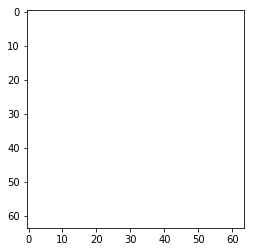

In [0]:
# Leer de una base de datos H5
with h5py.File('datasetCosas.h5','r') as h5data:
    ls=list(h5data.keys())
    print(ls)
    train_data=np.array(h5data.get('train_img')[:])
    train_labels=np.array(h5data.get('train_labels')[:])
    test_data=np.array(h5data.get('test_img')[:])
    test_labels=np.array(h5data.get('test_labels')[:])

print(train_data.shape)    
print(train_labels.shape) 
print(test_data.shape)    
print(test_labels.shape)  

# Funcion para cambiar de tamaño las imágenes para adpatarlas a la arquitectura
def resize_np (np_array):
    resized=[]
    for i in list(np_array):
        larger=cv2.resize(i,(64,64))
        resized.append(np.array(larger))
    return (np.array(resized).astype(np.float32))

# Funcion para cambiar labels a onehot
def one_hot_transformation(labels,n_classes):
    samples=labels.size
    one_hot_labels=np.zeros((samples,n_classes))
    for i in range(samples):
        one_hot_labels[i,labels[i]]=1
    return(one_hot_labels)

X_train=resize_np(train_data)
print(X_train.shape)
X_test=resize_np(test_data)
print(X_test.shape)
Y_train=one_hot_transformation(train_labels,n_classes)
print(Y_train.shape)
Y_test=one_hot_transformation(test_labels,n_classes)
print(Y_test.shape)

# mostrar un ejemplo
plt.imshow(X_train[0])

In [0]:
# Declaración de los pesos y los bias (weight & bias)
weights = {'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1],stddev=0.1)),
           'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],stddev=0.1)),
           'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes],stddev=0.1))
          }
biases = {'b1': tf.Variable(tf.truncated_normal([n_hidden_1],stddev=0.1)),
          'b2': tf.Variable(tf.truncated_normal([n_hidden_2],stddev=0.1)),
          'out': tf.Variable(tf.truncated_normal([n_classes],stddev=0.1))
         }

# Definición del perceptrón multicapa
def multilayer_perceptron(x):
    pool = tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')
    flat=tf.layers.flatten(pool)
    layer_1 = tf.add(tf.matmul(flat, weights['h1']), biases['b1']) # Hidden fully connected layer with 256 neurons
    relu_1=tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(relu_1, weights['h2']), biases['b2']) # Hidden fully connected layer with 256 neurons
    relu_2=tf.nn.relu(layer_2)
    out_layer = tf.matmul(relu_2, weights['out']) + biases['out'] # Output fully connected layer with a neuron for each class
    return out_layer
# Declarar la operación que aplica el MLP usando la información de entrada
logits = multilayer_perceptron(X2)
# Declarar las operaciónes que establecen la funcion de perdida y optimización 
# para el entrenamiento.
loss_op = tf.losses.softmax_cross_entropy(
    onehot_labels=Y,
    logits=logits,
    weights=1.0,
    scope=None,
    loss_collection=tf.GraphKeys.LOSSES,
    reduction=tf.losses.Reduction.SUM_BY_NONZERO_WEIGHTS
)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# Initializing the variables
init = tf.global_variables_initializer()

In [0]:
with tf.Session() as sess:
    sess.run(init)
    sess.run(model.pretrained())  # equivalent to nets.pretrained(model)
    for epoch in range(training_epochs):
        avg_cost = 0.
        #obtiene el numero de grupos en que queda dividida la base de datos
        total_batch = int(Y_train.shape[0]/batch_size) 
        # ciclo para entrenar con cada grupo de datos
        losses=[]
        for i in range(total_batch-1):
            batch_x= X_train[i*batch_size:(i+1)*batch_size]
            batch_y= Y_train[i*batch_size:(i+1)*batch_size]
            features = model.preprocess(batch_x)
            features = sess.run(model.get_middles(), {X: features})[-1]
            
            # Correr la funcion de perdida y la operacion de optimización 
            # con la respectiva alimentación del placeholder
            _,c =sess.run([train_op, loss_op],feed_dict={X2:features,Y:batch_y})
            # Promedio de resultados de  = c_api.TF_FinishOperation(op_desc)la funcion de pérdida
            losses.append(c)
            avg_cost += c / total_batch
        # Mostrar el resultado del entrenamiento por grupos
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
    print("Optimization Finished!")
    
    predict_op = tf.nn.softmax(logits)  # Apply softmax to logits
    correct_prediction = tf.equal(tf.argmax(predict_op, 1), tf.argmax(Y, 1)) 

    # Calcular la predicción sobre el conjunto de test 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    train_accuracy = []
    for i in range(total_batch-1):
      batch_x= X_train[i*batch_size:(i+1)*batch_size]
      batch_y= Y_train[i*batch_size:(i+1)*batch_size]
      features = model.preprocess(batch_x)
      features = sess.run(model.get_middles(), {X: features})[-1]
      train_accuracy.append(accuracy.eval({X2: features, Y: batch_y}))
    print("Train Accuracy:", sum(train_accuracy)/total_batch)
    
    test_accuracy = []
    for i in range(int(Y_test.shape[0]/batch_size)-1):
      batch_x= X_test[i*batch_size:(i+1)*batch_size]
      batch_y= Y_test[i*batch_size:(i+1)*batch_size]
      features = model.preprocess(batch_x)
      features = sess.run(model.get_middles(), {X: features})[-1]
      test_accuracy.append(accuracy.eval({X2: features, Y: batch_y}))
    print("Test Accuracy:", sum(test_accuracy)/int(Y_test.shape[0]/batch_size))

Epoch: 0001 cost=1.651926813
Epoch: 0002 cost=0.804281904
Epoch: 0003 cost=0.638585441
Epoch: 0004 cost=0.510294811
Epoch: 0005 cost=0.438384619
Epoch: 0006 cost=0.353689888
Epoch: 0007 cost=0.327079769
Epoch: 0008 cost=0.277006632
Epoch: 0009 cost=0.250365266
Epoch: 0010 cost=0.233811622
Epoch: 0011 cost=0.216175999
Epoch: 0012 cost=0.204989036
Epoch: 0013 cost=0.203918306
Epoch: 0014 cost=0.184365259
Epoch: 0015 cost=0.175817144
Epoch: 0016 cost=0.176123129
Epoch: 0017 cost=0.169819494
Epoch: 0018 cost=0.157454330
Epoch: 0019 cost=0.165021369
Epoch: 0020 cost=0.148987685
Optimization Finished!
Train Accuracy: 0.9613948861074822
Test Accuracy: 0.7848722956386671
